In [30]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [31]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [32]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [33]:

rfm = transactions.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (datetime(2024,12,31) - x.max()).days, 
    'TransactionID': 'count',                                           
    'TotalValue': 'sum'                                                 
}).rename(columns={
    'TransactionDate': 'Recency',
    'TransactionID': 'Frequency',
    'TotalValue': 'Monetary'
})


In [34]:
avg_transaction = transactions.groupby('CustomerID')['TotalValue'].mean().rename('AvgTransactionValue')
unique_products = transactions.groupby('CustomerID')['ProductID'].nunique().rename('UniqueProducts')

In [35]:
features = pd.merge(rfm, avg_transaction, on='CustomerID')
features = pd.merge(features, unique_products, on='CustomerID')

In [36]:
df = pd.merge(customers, features, on='CustomerID', how='left')

In [37]:
df['Tenure'] = (datetime(2024,12,31) - df['SignupDate']).dt.days

In [38]:
df.fillna({'Recency': 999, 'Frequency': 0, 'Monetary': 0, 'AvgTransactionValue': 0, 'UniqueProducts': 0}, inplace=True)

In [39]:
df = pd.get_dummies(df, columns=['Region'], drop_first=True)

In [40]:
final_df = df[['Recency', 'Frequency', 'Monetary', 'AvgTransactionValue', 'UniqueProducts', 'Tenure',
                'Region_Europe', 'Region_North America', 'Region_South America']]

In [41]:
log_cols = ['Frequency', 'Monetary', 'AvgTransactionValue', 'UniqueProducts']
final_df[log_cols] = final_df[log_cols].apply(lambda x: np.log1p(x))

C:\Users\sspon\AppData\Local\Temp\ipykernel_13184\4092354795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[log_cols] = final_df[log_cols].apply(lambda x: np.log1p(x))


In [42]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df)

In [43]:
pca = PCA(n_components=0.95)  # Retain 95% variance
pca_data = pca.fit_transform(scaled_data)
print(f"Reduced to {pca.n_components_} dimensions")

Reduced to 6 dimensions


C:\Users\sspon\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\sspon\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sspon\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\sspon\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

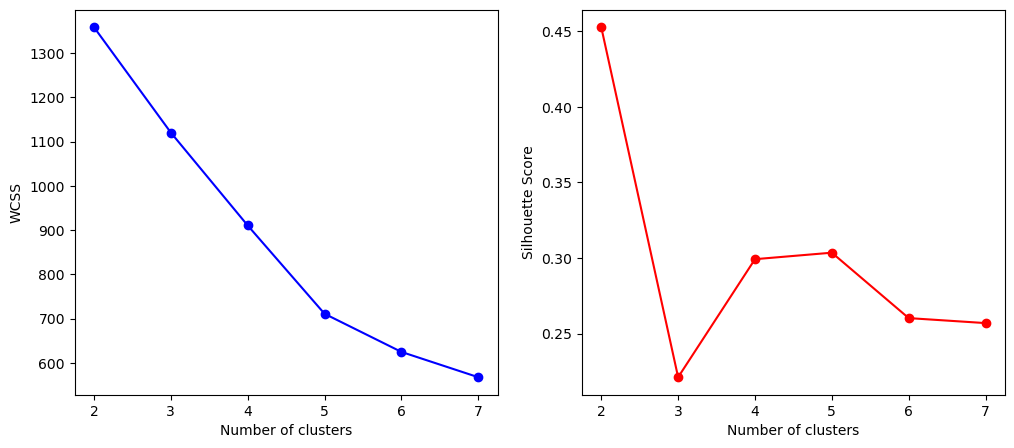

In [44]:
wcss = []
silhouettes = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_data)
    wcss.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(pca_data, labels))

# Plot results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1,2,2)
plt.plot(k_range, silhouettes, 'ro-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [45]:
optimal_k = 4  # Determined from elbow/silhouette analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(pca_data)

# Add clusters to original data
df['Cluster'] = clusters

C:\Users\sspon\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\sspon\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [46]:
cluster_profile = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'AvgTransactionValue': 'mean',
    'UniqueProducts': 'mean',
    'Tenure': 'mean',
    'Region_Europe': 'mean',
    'Region_North America': 'mean',
    'Region_South America': 'mean'
}).reset_index()

print(cluster_profile)

   Cluster     Recency  Frequency     Monetary  AvgTransactionValue  \
0        0   59.747368   5.400000  3854.376632           712.634063   
1        1  279.333333   1.066667   561.256000           491.993667   
2        2   71.500000   4.833333  3455.283542           716.959170   
3        3   69.523810   5.690476  3560.888810           650.816074   

   UniqueProducts      Tenure  Region_Europe  Region_North America  \
0        5.178947  585.715789       0.000000              0.000000   
1        1.066667  355.333333       0.133333              0.266667   
2        4.770833  549.541667       1.000000              0.000000   
3        5.642857  447.095238       0.000000              1.000000   

   Region_South America  
0              0.589474  
1              0.200000  
2              0.000000  
3              0.000000  


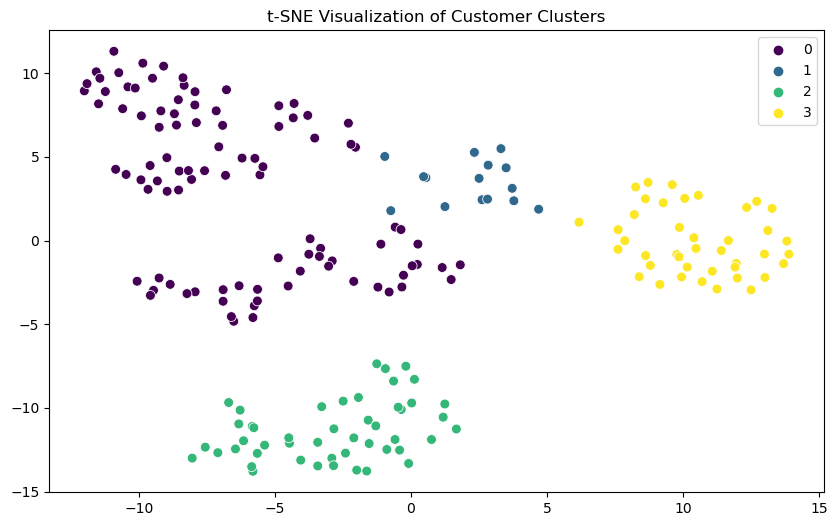

In [47]:
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(pca_data)

plt.figure(figsize=(10,6))
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=clusters, palette='viridis', s=50)
plt.title('t-SNE Visualization of Customer Clusters')
plt.show()

In [48]:
db_index = davies_bouldin_score(pca_data, clusters)
sil_score = silhouette_score(pca_data, clusters)

print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Silhouette Score: {sil_score:.3f}")

Davies-Bouldin Index: 1.233
Silhouette Score: 0.299


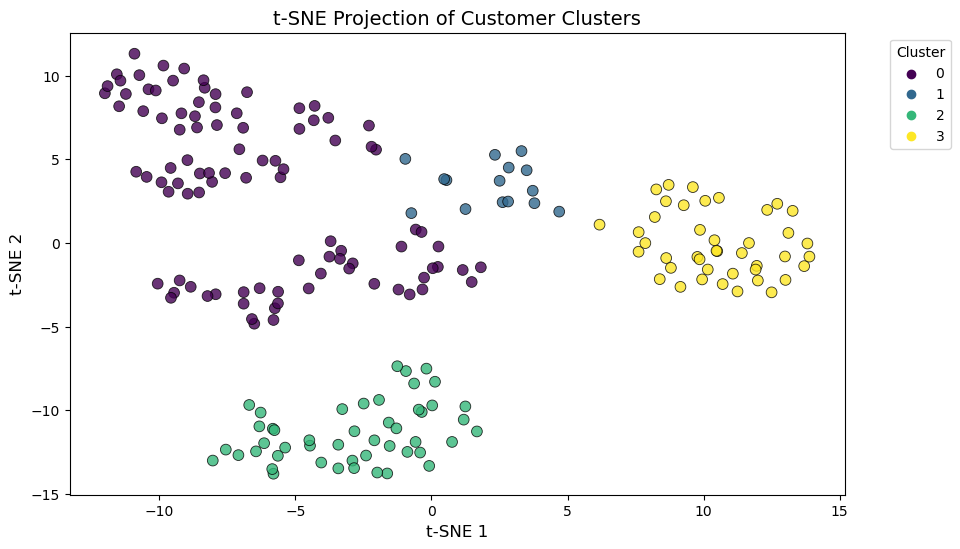

In [49]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=clusters, 
                palette='viridis', s=60, edgecolor='k', alpha=0.8)
plt.title('t-SNE Projection of Customer Clusters', fontsize=14)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()